# T-SNE on Amazon Food Reviews Using tfidf w2v Technique

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  index
2.  Id
3.  ProductId - unique identifier for the product
4.  UserId - unqiue identifier for the user
5.  ProfileName
6.  HelpfulnessNumerator - number of users who found the review helpful
7.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8.  Score - rating between 1 and 5
9.  Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, convert all the reviews into a vector using tfidf w2v technique then plot T-SNE. Separate all positive and negative reviews by blue and red colors respectively.**

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the data The dataset is available in two forms

1) .csv file

2) SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import nltk             #nltk = natural language tool kit
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
connection = sqlite3.connect('FinalAmazonFoodReviewsDataset.sqlite')

In [3]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [4]:
data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [5]:
data.shape

(364171, 12)

In [6]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [7]:
allPositiveReviews = pd.read_sql_query("SELECT * FROM Reviews WHERE Score = 'Positive'", connection)

In [8]:
allPositiveReviews.shape

(307061, 12)

In [9]:
allNegativeReviews = pd.read_sql_query("SELECT * FROM Reviews WHERE Score = 'Negative'", connection)

In [10]:
allNegativeReviews.shape

(57110, 12)

In [12]:
positiveReviews_500 = allPositiveReviews[3600:4100]

In [13]:
print(positiveReviews_500.shape)

(500, 12)


In [14]:
positiveReviews_500.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
3600,5710,6181,B005GHVL1O,A1G8ET9GA45DTX,veronica,0,0,Positive,1348012800,Dr Pepper,I got this product for my husband beause he lo...,got this product for husband beaus love pepper...
3601,5711,6182,B005GHVL1O,A3J2BJNYXP9ZUV,Az Will,0,0,Positive,1345939200,Dublin Dr. Pepper,Shipping was quite a bit but the bottles were ...,ship was quit bit but the bottl were all unbro...
3602,5712,6184,B004JQTDUO,A3GKY9OEJQYKEE,william,0,0,Positive,1328745600,GREAT COFFEE,"ESPECIALLY AS WE GET OLDER, THE LINING OF OUR ...",especi get older the line our stomach get more...
3603,5713,6186,B000UOFW9K,A1OPSTQ3ZHTPKZ,Lois C. Granzow,4,4,Positive,1215907200,"Product delicious, but shipping lacking.","I was delighted to find this product online, b...",was delight find this product onlin becaus can...
3604,5714,6187,B000UOFW9K,A2R6RA8FRBS608,Matthew G. Sherwin,6,7,Positive,1206748800,all right by me !!!,These chips are some of the best I've had--eve...,these chip are some the best ive theyr good da...


In [15]:
negativeReviews_500 = allNegativeReviews[8500:9000]

In [16]:
print(negativeReviews_500.shape)

(500, 12)


In [17]:
negativeReviews_500.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
8500,74527,81080,B004CT1NCY,AKFTHPU6CAWP,Jonathan R Evans,0,0,Negative,1344384000,been 2 months and still have not received the ...,Ordered the product in the middle of june and ...,order the product the middl june and have yet ...
8501,74536,81091,B000O9WEY2,A1PT8D39ZSDN2P,"T. Usrey ""tc_sting""",25,30,Negative,1330905600,Misleading Description,I purcahsed this oatmeal variety pack assuming...,purcahs this oatmeal varieti pack assum would ...
8502,74538,81093,B000O9WEY2,A30UUVP4H3IZT7,JJ21,8,10,Negative,1320019200,FALSE ADVERTISEMENT!,What is pictured and what you recieve is not t...,what pictur and what you reciev not the same t...
8503,74540,81095,B000O9WEY2,ABHU1BMZ7BO53,jmjudd99,5,6,Negative,1301184000,"Great product, disappointed in price. :(",I like the large variety of oatmeal but less t...,like the larg varieti oatmeal but less that we...
8504,74543,81098,B000O9WEY2,A18OXSORBLCYF5,J. Tsai,1,1,Negative,1341187200,Too Expensive and not what I expected.,The box I got is same as I can purchase from C...,the box got same can purchas from costco but m...


In [18]:
frames_1000 = [positiveReviews_500, negativeReviews_500]

In [19]:
FinalPositiveNegative = pd.concat(frames_1000)

In [20]:
FinalPositiveNegative.shape

(1000, 12)

In [21]:
FinalSortedPositiveNegative_1000 = FinalPositiveNegative.sort_values('Time', axis=0, ascending=True, inplace=False)

In [22]:
FinalSortedPositiveNegativeScore_1000 = FinalSortedPositiveNegative_1000["Score"]

In [24]:
print(FinalSortedPositiveNegative_1000.shape)
print(FinalSortedPositiveNegativeScore_1000.shape)

(1000, 12)
(1000,)


In [27]:
FinalSortedPositiveNegative_1000.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
3761,5907,6397,B000084EK7,A1Z54EM24Y40LL,c2,0,0,Positive,1090972800,What's in this?,This one is a great basic food. Whatever is in...,this one great basic food whatev cat realli fo...
3759,5905,6395,B000084EK5,A1Z54EM24Y40LL,c2,1,1,Positive,1090972800,Family favorite - looks like steak!,This is my cat's third favorite food. It's gr...,this cat third favorit food it great stuff the...
3744,5885,6373,B000084EKA,A1Z54EM24Y40LL,c2,0,0,Positive,1090972800,Not their best...,I think 9 Lives does a better job on this vari...,think live doe better job this varieti than fr...
3746,5887,6375,B000084EKC,A1Z54EM24Y40LL,c2,1,1,Positive,1090972800,Great food for all cats!,"According to my cat, this stuff is just great....",accord cat this stuff just great just lick him...
3750,5893,6381,B000084EKG,A1Z54EM24Y40LL,c2,2,2,Positive,1090972800,Awesome food!,This is my cat's favorite one. He just licks ...,this cat favorit one just lick that bowl clean...


## tfidf_w2v

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words = "english")
final_tf_idf = tf_idf_vect.fit_transform(FinalSortedPositiveNegative_1000['ProcessedText'].values)

In [39]:
print(type(final_tf_idf))

<class 'scipy.sparse.csr.csr_matrix'>


In [40]:
final_tf_idf.get_shape()

(1000, 31173)

In [28]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\GauravP\Anaconda3\lib\site-packages\gensim-3.2.0-py3.6-win-amd64.egg\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [29]:
i = 0
listOfSentences = []
for sentence in FinalSortedPositiveNegative_1000["ProcessedText"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences.append(subSentence)

In [32]:
print(FinalSortedPositiveNegative_1000['ProcessedText'].values[0:2])
print("\n")
print(listOfSentences[0:2])
print("\n")
print(type(listOfSentences))

['this one great basic food whatev cat realli for and mine except current cat realli doesnt like the ground varieti which what this will eat occasion onli buy about twice year previous cat had have more often and realli enjoy it hard judg what cat will eat your cat like ground give this one becaus realli seem big favorit'
 'this cat third favorit food it great stuff the gravi veri thick and the food look like bit steak slick off for your friend cat lick the bowl clean everi time and want more they should send discount for much this stuff buy buy the case that give you some idea']


[['this', 'one', 'great', 'basic', 'food', 'whatev', 'cat', 'realli', 'for', 'and', 'mine', 'except', 'current', 'cat', 'realli', 'doesnt', 'like', 'the', 'ground', 'varieti', 'which', 'what', 'this', 'will', 'eat', 'occasion', 'onli', 'buy', 'about', 'twice', 'year', 'previous', 'cat', 'had', 'have', 'more', 'often', 'and', 'realli', 'enjoy', 'it', 'hard', 'judg', 'what', 'cat', 'will', 'eat', 'your', 'cat'

In [37]:
import gensim
w2v_model=gensim.models.Word2Vec(listOfSentences, min_count=5, size=50, workers=4)   

In [50]:
# TF-IDF weighted Word2Vec
tfidf_features = tf_idf_vect.get_feature_names()

tfidf_w2v = []
reviews = 0

for sentence in listOfSentences:
    sentenceVector = np.zeros(50)
    weightSum = 0
    for word in sentence:
        try:
            W2V_Vector = w2v_model.wv[word]
            tfidf = final_tf_idf[reviews, tfidf_features.index(word)]
            sentenceVector += (W2V_Vector * tfidf)
            weightSum += tfidf
        except:
            pass
    sentenceVector /= weightSum
    tfidf_w2v.append(sentenceVector)
    reviews += 1

In [59]:
from sklearn.preprocessing import StandardScaler
standardized_tfidf_w2v = StandardScaler().fit_transform(tfidf_w2v)
print(standardized_tfidf_w2v.shape)
print(type(standardized_tfidf_w2v))

(1000, 50)
<class 'numpy.ndarray'>


## TSNE OF TFIDF W2V

In [60]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=500, n_iter=2500)

tsne_data = model.fit_transform(standardized_tfidf_w2v)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, FinalSortedPositiveNegativeScore_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

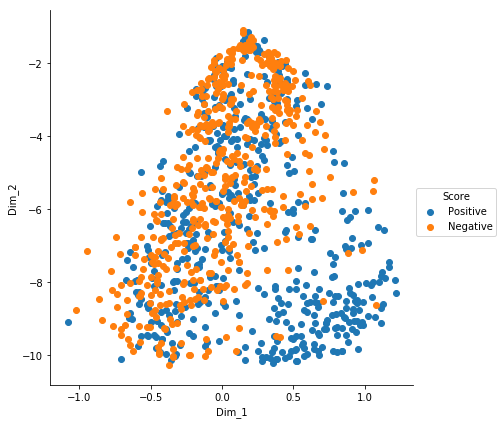

In [61]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plot.scatter, 'Dim_1', 'Dim_2').add_legend()
plot.show()

In [62]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3500)

tsne_data = model.fit_transform(standardized_tfidf_w2v)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, FinalSortedPositiveNegativeScore_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

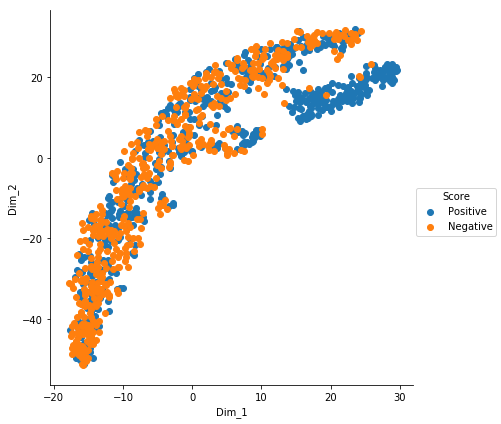

In [63]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plot.scatter, 'Dim_1', 'Dim_2').add_legend()
plot.show()

In [64]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=100, n_iter=3500)

tsne_data = model.fit_transform(standardized_tfidf_w2v)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, FinalSortedPositiveNegativeScore_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

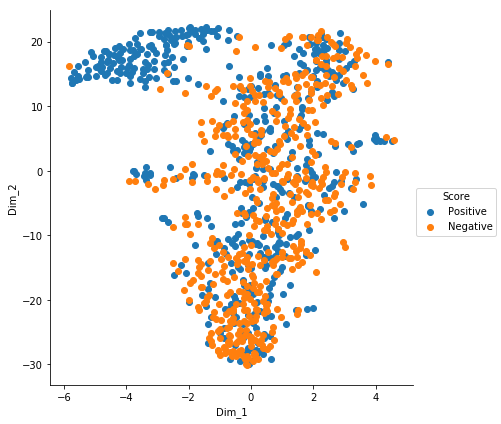

In [65]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plot.scatter, 'Dim_1', 'Dim_2').add_legend()
plot.show()

In [66]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=200, n_iter=2500)

tsne_data = model.fit_transform(standardized_tfidf_w2v)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, FinalSortedPositiveNegativeScore_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

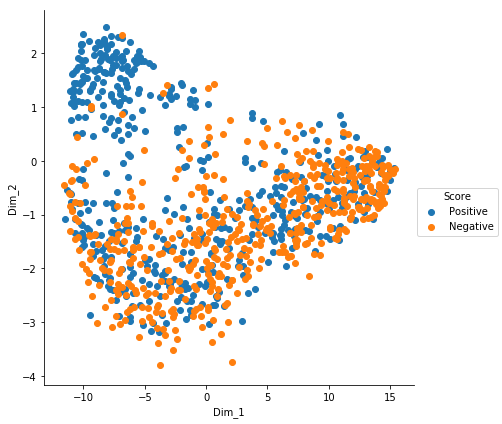

In [67]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plot.scatter, 'Dim_1', 'Dim_2').add_legend()
plot.show()